In [5]:
# import pandas as pd

# # === INPUT FILE PATHS ===
# metadata_path = "/Users/priyank/Desktop/Reuslts/sobol_metadata_individual_sensor_categorical.csv"
# metrics_path = "/Users/priyank/Desktop/llm_rag/downloads/metrics_20250519_131217_cleaned.xlsx"
# output_path = "sobol_ready_output_run2.csv"

# # === Load metadata ===
# metadata_df = pd.read_csv(metadata_path)
# metadata_df['File'] = metadata_df['json_path'].apply(lambda x: x.split('/')[-1].replace('.json', ''))

# # === Load Excel Metrics ===
# xls = pd.ExcelFile(metrics_path)
# node_metrics = xls.parse("NodeMetrics")
# edge_metrics = xls.parse("EdgeMetrics")
# ged_metrics = xls.parse("GEDMetrics")

# # === Node Metrics (Role == "Overall") ===
# node_overall = node_metrics[node_metrics["Role"] == "Overall"]

# # Check for duplicates
# dupes = node_overall.duplicated(subset=["File", "Critical Event"], keep=False)
# duplicate_rows = node_overall[dupes]

# if not duplicate_rows.empty:
#     print("⚠️ Duplicate 'Overall' rows found for some File + Critical Event combinations:")
#     print(duplicate_rows[["File", "Critical Event"]])
# else:
#     print("✅ No duplicate Overall rows per File + Critical Event")

# # Average Node F1/Jaccard over all CEs per File (enforced by column name)
# node_agg = node_overall.groupby("File")[["F1", "Jaccard"]].mean().reset_index()
# node_agg = node_agg.rename(columns={"F1": "Node_F1", "Jaccard": "Node_Jaccard"})

# # === Edge Metrics (Edge Type == "Overall") ===
# edge_overall = edge_metrics[edge_metrics["Edge Type"] == "Overall"]
# edge_agg = edge_overall.groupby("File")[["F1", "Jaccard"]].mean().reset_index()
# edge_agg = edge_agg.rename(columns={"F1": "Edge_F1", "Jaccard": "Edge_Jaccard"})

# # === GED Metrics (average GED per CE, then per File) ===
# ged_agg = ged_metrics.groupby(["File", "Critical Event"])[["GED"]].mean().reset_index()
# ged_agg_file_avg = ged_agg.groupby("File")[["GED"]].mean().reset_index()

# # === Merge all metrics ===
# all_metrics = ged_agg_file_avg.merge(node_agg, on="File").merge(edge_agg, on="File")
# final_df = metadata_df.merge(all_metrics, on="File")

# # === Check for invalid F1/Jaccard values ===
# invalid = final_df[
#     (final_df["Node_F1"] > 1.0) | (final_df["Node_F1"] < 0.0) |
#     (final_df["Node_Jaccard"] > 1.0) | (final_df["Node_Jaccard"] < 0.0) |
#     (final_df["Edge_F1"] > 1.0) | (final_df["Edge_F1"] < 0.0) |
#     (final_df["Edge_Jaccard"] > 1.0) | (final_df["Edge_Jaccard"] < 0.0)
# ]

# if not invalid.empty:
#     print("❌ Invalid F1 or Jaccard values found (outside [0.0, 1.0]):")
#     print(invalid[["File", "Node_F1", "Node_Jaccard", "Edge_F1", "Edge_Jaccard"]])
# else:
#     print("✅ All Node/Edge F1 and Jaccard values are within [0.0, 1.0]")

# # === Save ===
# final_df.to_csv(output_path, index=False)
# print(f"✅ Final Sobol-ready file saved as: {output_path}")


import pandas as pd
from pathlib import Path

# === INPUT/OUTPUT PATHS ===
metadata_path = "/Users/priyank/Desktop/Reuslts/sobol_metadata_individual_sensor_categorical_v2.csv"
metrics_path = "/Users/priyank/Desktop/llm_rag/downloads/metrics_sobol1_1024_llama_v2_cleaned.xlsx"
output_path = "sobol_ready_output_run2_llama_v2.csv"

# === Helper: Normalize file names (drop .json/.txt) ===
def normalize_filename(path_str):
    return Path(str(path_str)).stem.strip()

# === Load Sobol metadata and normalize ===
metadata_df = pd.read_csv(metadata_path)
metadata_df['File'] = metadata_df['json_path'].apply(normalize_filename)

# === Load Excel metrics ===
xls = pd.ExcelFile(metrics_path)
node_metrics = xls.parse("NodeMetrics")
edge_metrics = xls.parse("EdgeMetrics")
ged_metrics = xls.parse("GEDMetrics")

# Normalize filenames across all metrics
for df in [node_metrics, edge_metrics, ged_metrics]:
    df['File'] = df['File'].astype(str).apply(normalize_filename)

# === Node Metrics (Role == "Overall") ===
node_overall = node_metrics[node_metrics["Role"] == "Overall"]
node_agg = node_overall.groupby("File")[["F1", "Jaccard"]].mean().reset_index()
node_agg = node_agg.rename(columns={"F1": "Node_F1", "Jaccard": "Node_Jaccard"})

# === Edge Metrics (Edge Type == "Overall") ===
edge_overall = edge_metrics[edge_metrics["Edge Type"] == "Overall"]
edge_agg = edge_overall.groupby("File")[["F1", "Jaccard"]].mean().reset_index()
edge_agg = edge_agg.rename(columns={"F1": "Edge_F1", "Jaccard": "Edge_Jaccard"})

# === GED Metrics (average GED per CE, then per File) ===
ged_agg = ged_metrics.groupby(["File", "Critical Event"])[["GED"]].mean().reset_index()
ged_agg_file_avg = ged_agg.groupby("File")[["GED"]].mean().reset_index()

# === Merge all metrics ===
all_metrics = ged_agg_file_avg.merge(node_agg, on="File").merge(edge_agg, on="File")

# === Merge with Sobol metadata (only those with metrics) ===
final_df = metadata_df.merge(all_metrics, on="File", how="inner")

# === Check for invalid values ===
invalid = final_df[
    (final_df["Node_F1"] > 1.0) | (final_df["Node_F1"] < 0.0) |
    (final_df["Node_Jaccard"] > 1.0) | (final_df["Node_Jaccard"] < 0.0) |
    (final_df["Edge_F1"] > 1.0) | (final_df["Edge_F1"] < 0.0) |
    (final_df["Edge_Jaccard"] > 1.0) | (final_df["Edge_Jaccard"] < 0.0)
]

if not invalid.empty:
    print("❌ Invalid F1 or Jaccard values found (outside [0.0, 1.0]):")
    print(invalid[["File", "Node_F1", "Node_Jaccard", "Edge_F1", "Edge_Jaccard"]])
else:
    print("✅ All Node/Edge F1 and Jaccard values are within [0.0, 1.0]")

# === Summary ===
print(f"📊 Total samples in Sobol metadata: {len(metadata_df)}")
print(f"📊 Samples matched with valid metrics: {len(final_df)}")

# === Save merged output ===
final_df.to_csv(output_path, index=False)
print(f"✅ Final Sobol-ready file saved to: {output_path}")


✅ All Node/Edge F1 and Jaccard values are within [0.0, 1.0]
📊 Total samples in Sobol metadata: 24576
📊 Samples matched with valid metrics: 8192
✅ Final Sobol-ready file saved to: sobol_ready_output_run2_llama_v2.csv


In [ ]:
# import pandas as pd
# from SALib.analyze import sobol
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# import numpy as np
# # === CONFIG ===
# INPUT_CSV = "sobol_ready_output_run2.csv"
# PER_MODEL_OUTPUT = "sobol_s1_st_per_model_run2.csv"
# S2_OUTPUT = "sobol_s2_per_model_run2.csv"
# # PLOTS_DIR = "sobol_plots"
# N = 256
# # os.makedirs(PLOTS_DIR, exist_ok=True)

# sobol_problem = {
#     'num_vars': 3,
#     'names': ['prompt_type', 'prompt_strictness', 'context_type'],
#     'bounds': [[0, 3], [0, 3], [0, 3]]  
# }

# metrics = ['Node_F1', 'Edge_F1']


# # === Load data ===
# df = pd.read_csv(INPUT_CSV)
# expected_samples = N * (2 * len(sobol_problem['names']) + 2)

# # === Remap model names ===
# model_name_map = {
#     "LLaMA-3-8B": "LLaMA-3-Instruct",
#     "Mistral-7B": "Mistral-Instruct",
#     "Qwen-7B": "Qwen-2.5-Instruct"
# }
# df["model"] = df["model"].map(model_name_map).fillna(df["model"])


# # === Per-Model Sobol Analysis ===
# per_model_results = []
# s2_results = []

# for model in df['model'].unique():
#     model_df = df[df['model'] == model].reset_index(drop=True)
#     for metric in metrics:
#         Y = model_df[metric].values
#         if len(Y) < expected_samples:
#             print(f"Skipping {model} {metric}: only {len(Y)} samples (expected {expected_samples})")
#             continue
#         try:
#             Si = sobol.analyze(
#                 sobol_problem, Y,
#                 calc_second_order=True,
#                 num_resamples=1000,
#                 print_to_console=False
#             )

#             # First-order and total-order
#             for i, param in enumerate(sobol_problem['names']):
#                 per_model_results.append({
#                     "Model": model,
#                     "Metric": metric,
#                     "Parameter": param,
#                     "S1": Si['S1'][i],
#                     "S1_conf": Si['S1_conf'][i],
#                     "ST": Si['ST'][i],
#                     "ST_conf": Si['ST_conf'][i]
#                 })

#             # Second-order
#             for i in range(len(sobol_problem['names'])):
#                 for j in range(i + 1, len(sobol_problem['names'])):
#                     s2_results.append({
#                         "Model": model,
#                         "Metric": metric,
#                         "Param_1": sobol_problem['names'][i],
#                         "Param_2": sobol_problem['names'][j],
#                         "S2": Si['S2'][i, j],
#                         "S2_conf": Si['S2_conf'][i, j]
#                     })

#         except Exception as e:
#             print(f"Error in per-model analysis for {model} {metric}: {e}")

# # === Save results ===
# per_model_df = pd.DataFrame(per_model_results)
# per_model_df.to_csv(PER_MODEL_OUTPUT, index=False)
# s2_df = pd.DataFrame(s2_results)
# s2_df.to_csv(S2_OUTPUT, index=False)

# # === Plotting S1 and ST ===
# def plot_s1_st(df, title_prefix):
#     for metric in df['Metric'].unique():
#         metric_df = df[df['Metric'] == metric]
#         fig, ax = plt.subplots(figsize=(10, 5))
#         y_labels = []
#         y_pos = []
#         spacing = 0.25

#         for idx, (_, row) in enumerate(metric_df.iterrows()):
#             y = idx
#             y_labels.append(f"{row['Model']} | {row['Parameter']}")
#             y_pos.append(y)
#             ax.errorbar(row['S1'], y - spacing, xerr=row['S1_conf'], fmt='o', color='blue', label='S1' if idx == 0 else "")
#             ax.errorbar(row['ST'], y + spacing, xerr=row['ST_conf'], fmt='s', color='orange', label='ST' if idx == 0 else "")

#         ax.set_yticks(y_pos)
#         ax.set_yticklabels(y_labels)
#         ax.axvline(0, color='black', linestyle='--', linewidth=0.7)
#         ax.set_title(f"{title_prefix} - Sobol Indices for {metric}")
#         ax.set_ylabel("Model + Parameter Pair")
#         ax.set_xlabel("Sensitivity Index Value")
#         ax.invert_yaxis()
#         ax.legend()
#         plt.tight_layout()
#         plt.savefig(os.path.join(PLOTS_DIR, f"{title_prefix}_{metric}_S1_ST.png"))
#         plt.close()
        
# def plot_s2_heatmap(df):
#     params = sobol_problem['names']
#     for model in df["Model"].unique():
#         for metric in df["Metric"].unique():
#             subset = df[(df["Model"] == model) & (df["Metric"] == metric)]
#             if subset.empty:
#                 continue

#             # Create symmetric S2 matrix
#             matrix = pd.DataFrame(np.nan, index=params, columns=params)
#             for _, row in subset.iterrows():
#                 p1, p2 = row["Param_1"], row["Param_2"]
#                 matrix.loc[p1, p2] = row["S2"]
#                 matrix.loc[p2, p1] = row["S2"]  # make symmetric

#             fig, ax = plt.subplots(figsize=(6, 5))
#             sns.heatmap(matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1, square=True, cbar=True, ax=ax)
#             ax.set_title(f"S2 Indices – {model} – {metric}")
#             plt.tight_layout()
#             # plt.savefig(os.path.join(PLOTS_DIR, f"S2_{model}_{metric}.png"))
#             # plt.close(fig)


# # === Generate plots ===
# if not per_model_df.empty:
#     plot_s1_st(per_model_df, "Per Model")
# if not s2_df.empty:
#     plot_s2_heatmap(s2_df)

# print("✅ Sobol S1/ST/S2 analysis and plotting complete.")


/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


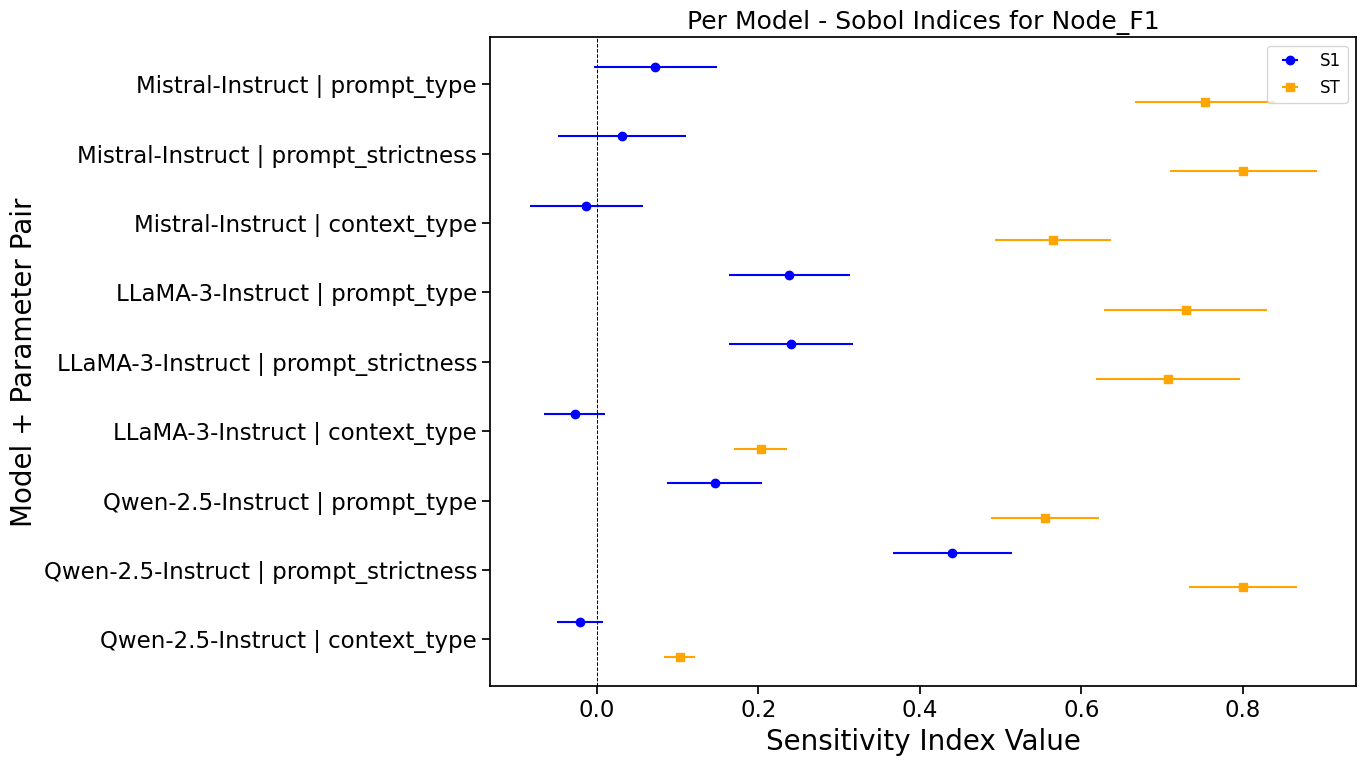

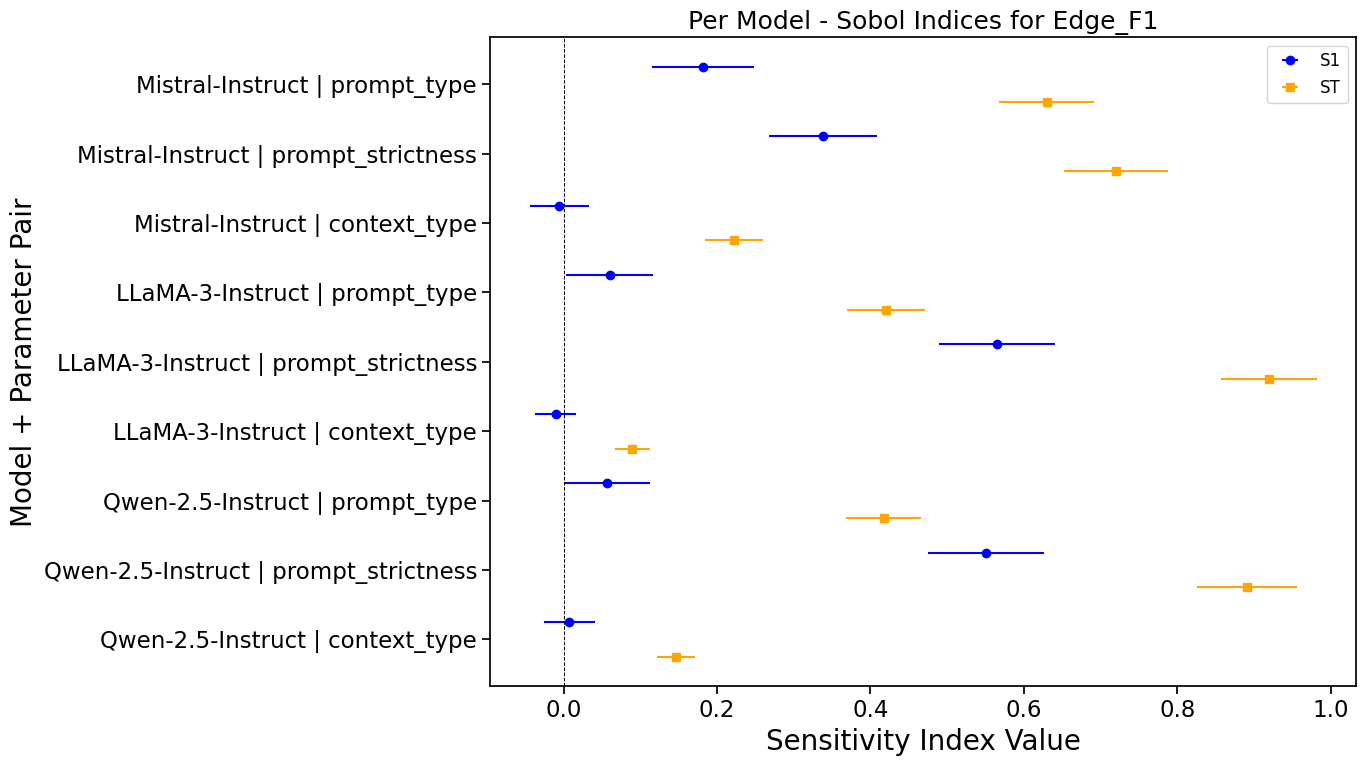

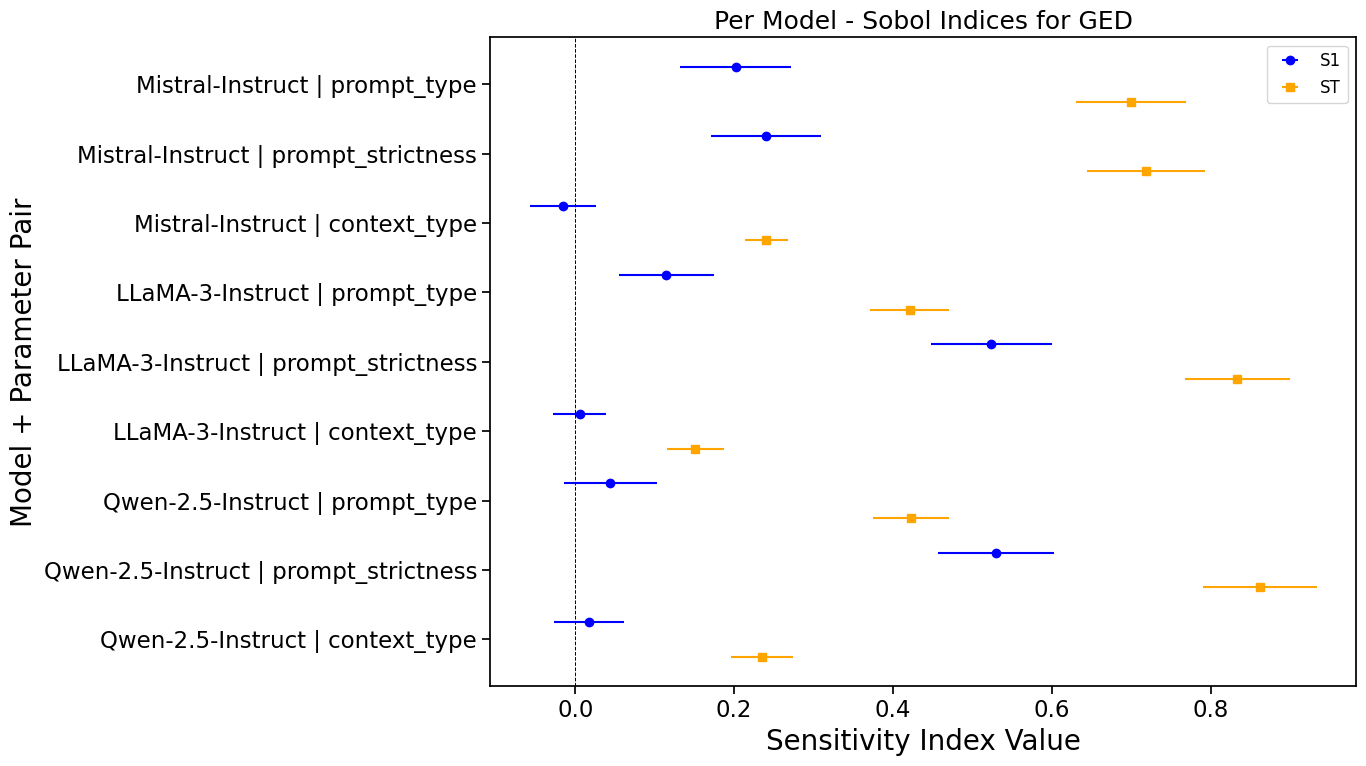

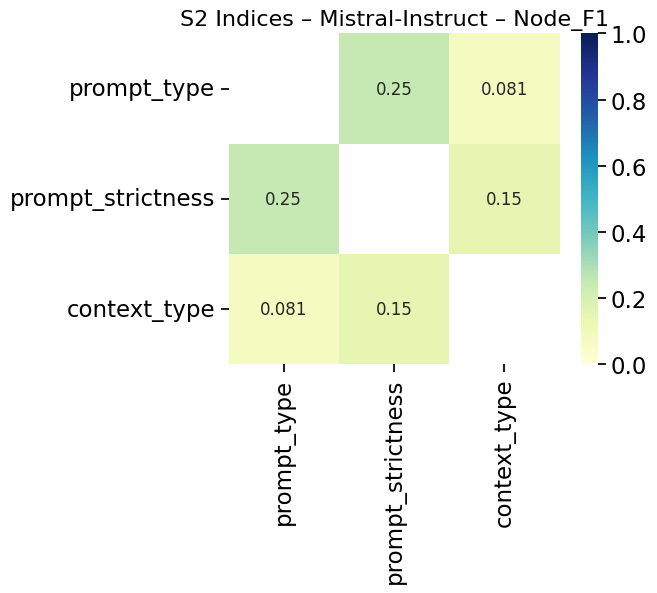

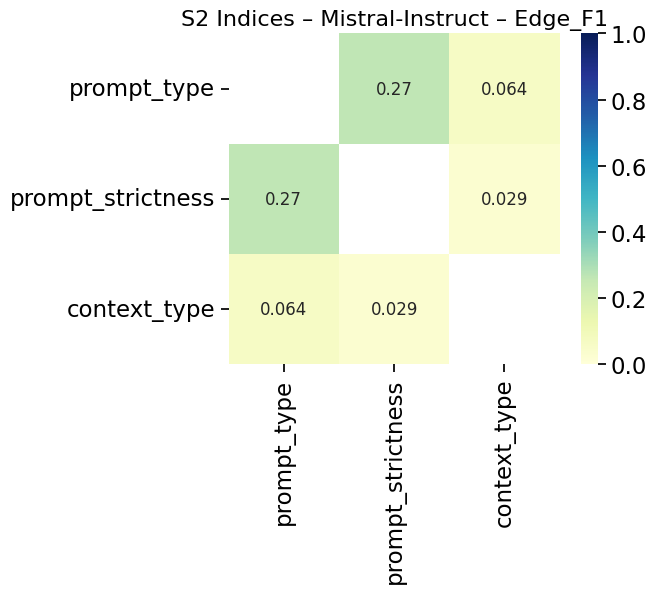

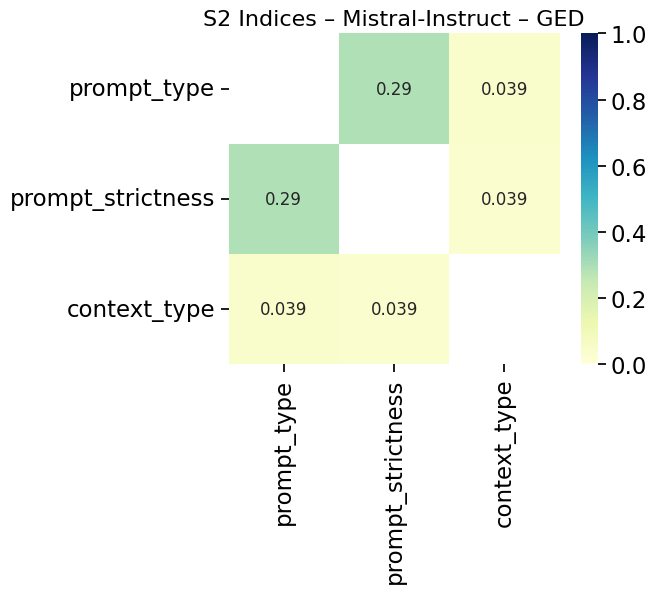

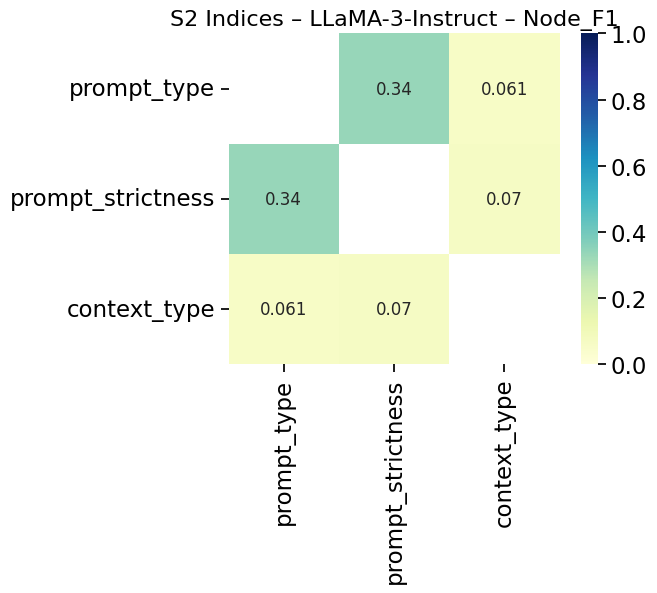

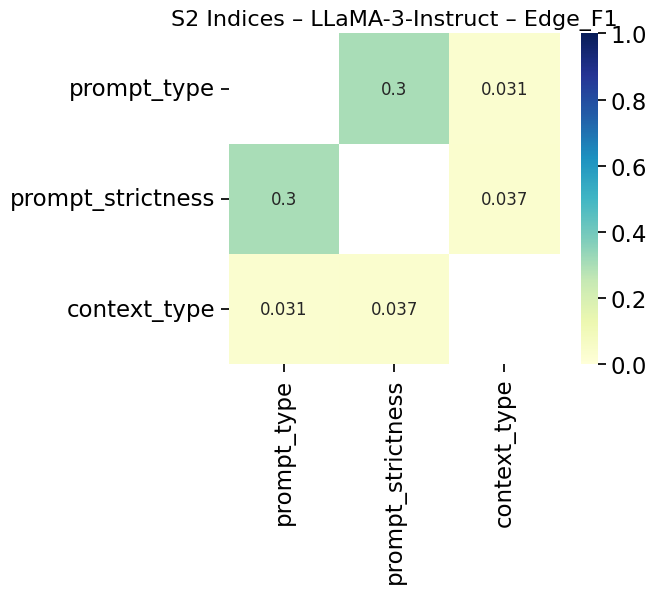

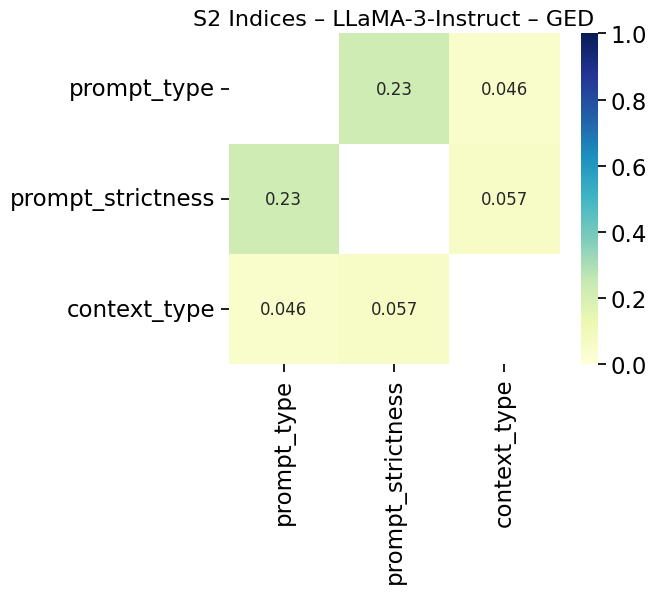

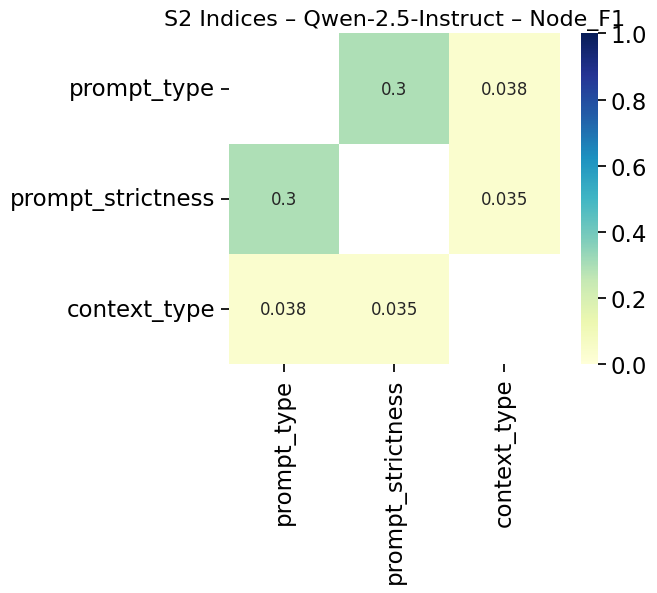

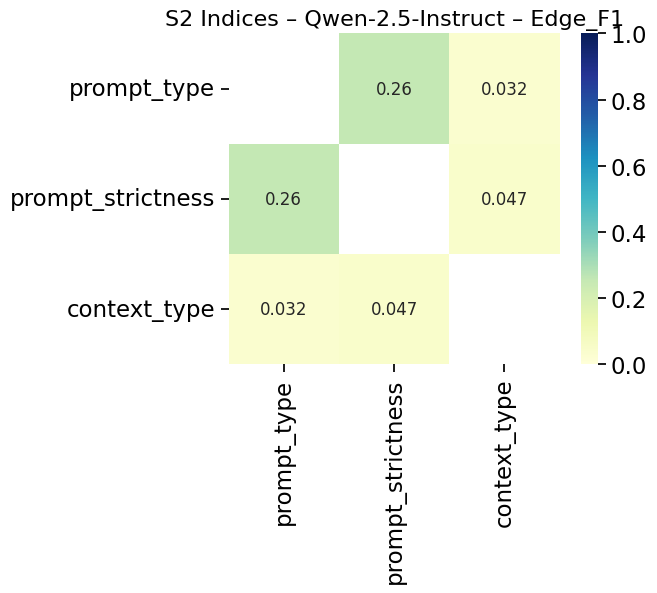

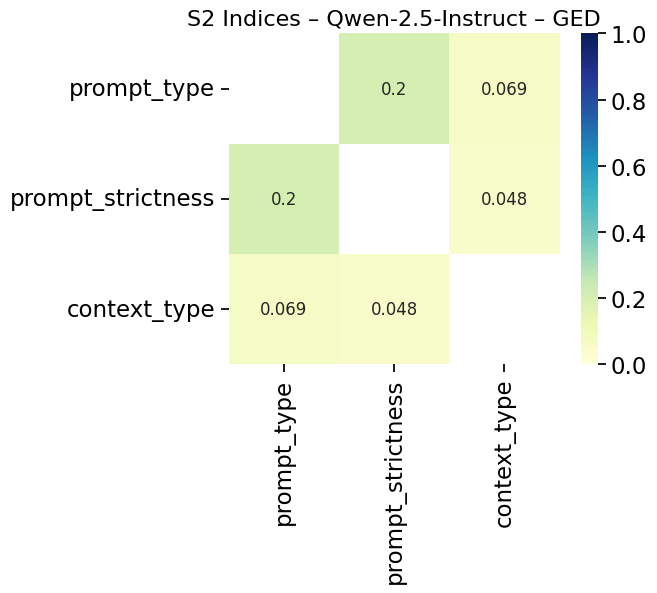

In [1]:
# Rewrite the plotting portion of the Sobol script with updated font settings for thesis-quality figures

import pandas as pd
from SALib.analyze import sobol
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# === CONFIG ===
INPUT_CSV = "combined_sobol_run2_v2.csv"
PER_MODEL_OUTPUT = "sobol_s1_st_per_model_run2_1024.csv"
S2_OUTPUT = "sobol_s2_per_model_run2_1024.csv"
N = 1024
PLOTS_DIR = "sobol_plots"

# Set font sizes for thesis-quality figures
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 16
})
sns.set_context("notebook", font_scale=1.5)

# Sobol problem definition
sobol_problem = {
    'num_vars': 3,
    'names': ['prompt_type', 'prompt_strictness', 'context_type'],
    'bounds': [[0, 3], [0, 3], [0, 3]]
}

metrics = ['Node_F1', 'Edge_F1', 'GED']

# Load data
df = pd.read_csv(INPUT_CSV)
expected_samples = N * (2 * len(sobol_problem['names']) + 2)

# Remap model names
model_name_map = {
    "LLaMA-3-8B": "LLaMA-3-Instruct",
    "Mistral-7B": "Mistral-Instruct",
    "Qwen-7B": "Qwen-2.5-Instruct"
}
df["model"] = df["model"].map(model_name_map).fillna(df["model"])

# Per-Model Sobol Analysis
per_model_results = []
s2_results = []

for model in df['model'].unique():
    model_df = df[df['model'] == model].reset_index(drop=True)
    for metric in metrics:
        Y = model_df[metric].values
        if len(Y) < expected_samples:
            print(f"Skipping {model} {metric}: only {len(Y)} samples (expected {expected_samples})")
            continue
        try:
            Si = sobol.analyze(
                sobol_problem, Y,
                calc_second_order=True,
                num_resamples=1000,
                print_to_console=False
            )
            for i, param in enumerate(sobol_problem['names']):
                per_model_results.append({
                    "Model": model,
                    "Metric": metric,
                    "Parameter": param,
                    "S1": Si['S1'][i],
                    "S1_conf": Si['S1_conf'][i],
                    "ST": Si['ST'][i],
                    "ST_conf": Si['ST_conf'][i]
                })
            for i in range(len(sobol_problem['names'])):
                for j in range(i + 1, len(sobol_problem['names'])):
                    s2_results.append({
                        "Model": model,
                        "Metric": metric,
                        "Param_1": sobol_problem['names'][i],
                        "Param_2": sobol_problem['names'][j],
                        "S2": Si['S2'][i, j],
                        "S2_conf": Si['S2_conf'][i, j]
                    })

        except Exception as e:
            print(f"Error in per-model analysis for {model} {metric}: {e}")

# Save results
per_model_df = pd.DataFrame(per_model_results)
per_model_df.to_csv(PER_MODEL_OUTPUT, index=False)
s2_df = pd.DataFrame(s2_results)
s2_df.to_csv(S2_OUTPUT, index=False)

# Plotting S1 and ST with enhanced fonts
def plot_s1_st(df, title_prefix):
    for metric in df['Metric'].unique():
        metric_df = df[df['Metric'] == metric]
        fig, ax = plt.subplots(figsize=(14, 8))
        y_labels = []
        y_pos = []
        spacing = 0.25

        for idx, (_, row) in enumerate(metric_df.iterrows()):
            y = idx
            y_labels.append(f"{row['Model']} | {row['Parameter']}")
            y_pos.append(y)
            ax.errorbar(row['S1'], y - spacing, xerr=row['S1_conf'], fmt='o', color='blue', label='S1' if idx == 0 else "")
            ax.errorbar(row['ST'], y + spacing, xerr=row['ST_conf'], fmt='s', color='orange', label='ST' if idx == 0 else "")

        ax.set_yticks(y_pos)
        ax.set_yticklabels(y_labels)
        ax.axvline(0, color='black', linestyle='--', linewidth=0.7)
        ax.set_title(f"{title_prefix} - Sobol Indices for {metric}", fontsize=18)
        ax.set_ylabel("Model + Parameter Pair", fontsize=20)
        ax.set_xlabel("Sensitivity Index Value", fontsize=20)
        ax.invert_yaxis()
        ax.legend(fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f"{title_prefix}_{metric}_S1_ST_1024.png"))
        plt.show()

# Plot S2 heatmaps with enhanced fonts
def plot_s2_heatmap(df):
    params = sobol_problem['names']
    for model in df["Model"].unique():
        for metric in df["Metric"].unique():
            subset = df[(df["Model"] == model) & (df["Metric"] == metric)]
            if subset.empty:
                continue
            matrix = pd.DataFrame(np.nan, index=params, columns=params)
            for _, row in subset.iterrows():
                p1, p2 = row["Param_1"], row["Param_2"]
                matrix.loc[p1, p2] = row["S2"]
                matrix.loc[p2, p1] = row["S2"]
            fig, ax = plt.subplots(figsize=(7, 6))
            sns.heatmap(matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1, square=True,
                        cbar=True, ax=ax, annot_kws={"size": 12})
            ax.set_title(f"S2 Indices – {model} – {metric}", fontsize=16)
            plt.tight_layout()
            plt.show()

# Generate plots
if not per_model_df.empty:
    plot_s1_st(per_model_df, "Per Model")
if not s2_df.empty:
    plot_s2_heatmap(s2_df)


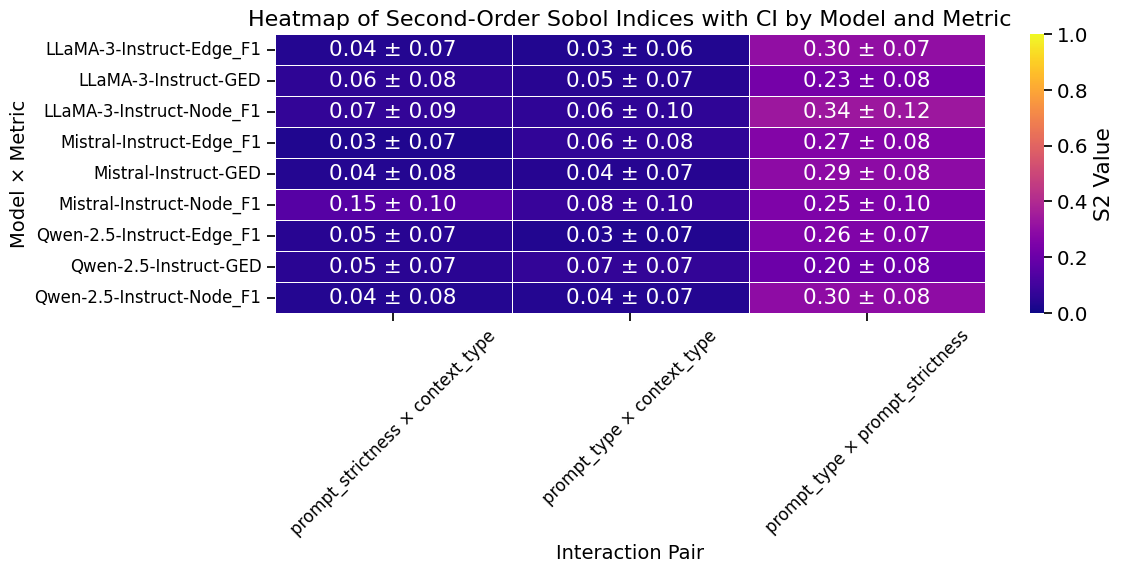

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate interaction labels
s2_df["Interaction"] = s2_df["Param_1"] + " × " + s2_df["Param_2"]

# Create formatted annotation string with ±
s2_df["S2_with_CI"] = s2_df.apply(
    lambda row: f"{row['S2']:.2f} ± {row['S2_conf']:.2f}", axis=1
)

# Pivot data
s2_heatmap_values = s2_df.pivot_table(
    index=["Model", "Metric"],
    columns="Interaction",
    values="S2"
)
s2_heatmap_annots = s2_df.pivot_table(
    index=["Model", "Metric"],
    columns="Interaction",
    values="S2_with_CI",
    aggfunc="first"
)

# Update global font sizes
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.titlesize": 16
})
sns.set_context("notebook", font_scale=1.3)


# Create a clean figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the heatmap — allow Seaborn to handle the colorbar once
sns.heatmap(
    s2_heatmap_values,
    annot=s2_heatmap_annots,
    fmt="",
    cmap="plasma",
    vmin=0,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"label": "S2 Value"},
    ax=ax
)

# Set titles and labels with larger font sizes
ax.set_title("Heatmap of Second-Order Sobol Indices with CI by Model and Metric", fontsize=16)
ax.set_xlabel("Interaction Pair", fontsize=14)
ax.set_ylabel("Model × Metric", fontsize=14)
ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)

# (DO NOT add a second colorbar manually like: ax.figure.colorbar(...))

plt.tight_layout()
plt.show()


# Select best 2/3 best performing combinations per model

In [19]:
import pandas as pd

# === CONFIG ===
CSV_PATH = "sobol_ready_output_run2_v2.csv"  # Replace with your actual file path
METRIC_COLUMNS = ['Node_F1', 'Edge_F1']
GROUP_COLUMNS = ['model', 'prompt_type', 'prompt_strictness']

# === LOAD DATA ===
df = pd.read_csv(CSV_PATH)

# === FILTER FOR SUCCESSFUL RUNS ===
# df = df[df['status'] == 'success']

# === COMPUTE AVERAGE METRICS ===
agg = df.groupby(GROUP_COLUMNS)[METRIC_COLUMNS].mean().reset_index()

# === ADD COMPOSITE SCORE ===
agg['Avg_Node_Edge_F1'] = agg[['Node_F1', 'Edge_F1']].mean(axis=1)

# === RANK WITHIN EACH MODEL ===
agg['rank'] = agg.groupby('model')['Avg_Node_Edge_F1'].rank(method='min', ascending=False)

# === GET TOP 3 PER MODEL ===
top3_per_model = agg[agg['rank'] <= 3].sort_values(['model', 'rank'])

# === DISPLAY ===
print("Top 3 Parameter Combinations Per Model (by Avg Node + Edge F1):")
print(top3_per_model[['model', 'prompt_type', 'prompt_strictness', 'Node_F1', 'Edge_F1', 'Avg_Node_Edge_F1']])


Top 3 Parameter Combinations Per Model (by Avg Node + Edge F1):
         model prompt_type prompt_strictness   Node_F1   Edge_F1  \
6   LLaMA-3-8B        zero              high  0.983205  0.980038   
0   LLaMA-3-8B         cot              high  0.979999  0.976117   
2   LLaMA-3-8B         cot            medium  0.979236  0.975340   
15  Mistral-7B        zero              high  0.919189  0.911686   
11  Mistral-7B         cot            medium  0.876874  0.711034   
9   Mistral-7B         cot              high  0.846153  0.598172   
20     Qwen-7B         cot            medium  0.979236  0.975340   
26     Qwen-7B        zero            medium  0.977056  0.972520   
23     Qwen-7B         few            medium  0.907748  0.771751   

    Avg_Node_Edge_F1  
6           0.981621  
0           0.978058  
2           0.977288  
15          0.915437  
11          0.793954  
9           0.722163  
20          0.977288  
26          0.974788  
23          0.839749  


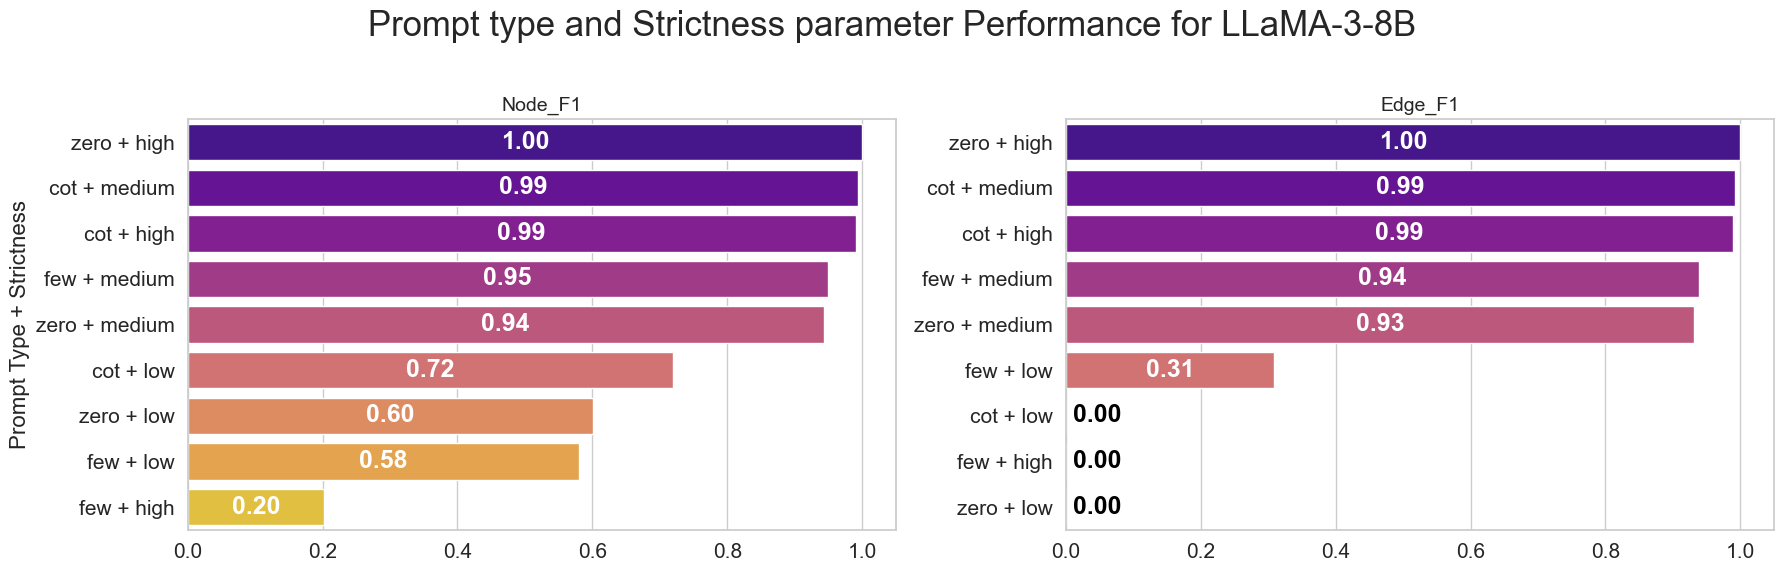

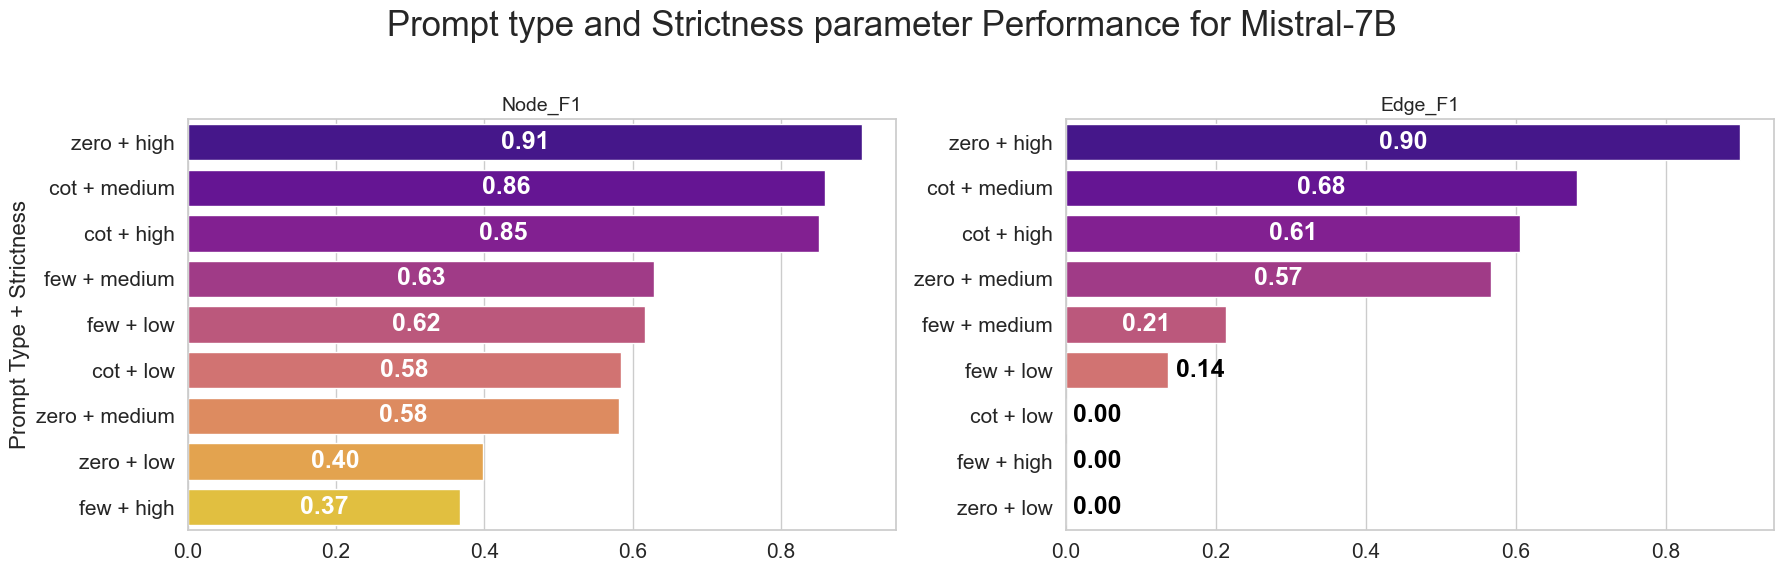

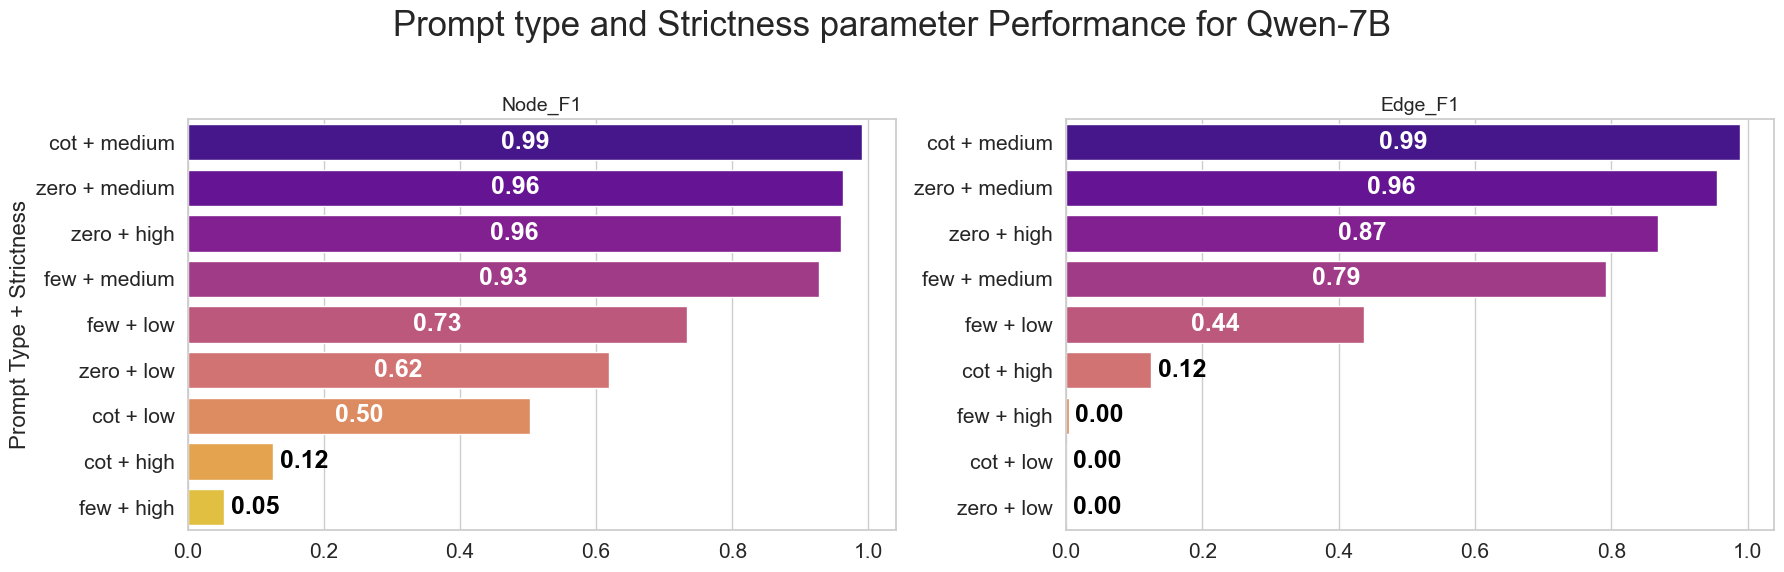

In [7]:
# Re-import everything needed after code reset
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset again
csv_path = Path("combined_sobol_run2_v2.csv")
df = pd.read_csv(csv_path)

# Combine prompt_type and strictness into a single label
df['prompt_combo'] = df['prompt_type'] + " + " + df['prompt_strictness']

# Aggregate metrics over all context types
agg = df.groupby(['model', 'prompt_combo'])[['Node_F1', 'Edge_F1', 'GED']].mean().reset_index()

# Set seaborn style
sns.set(style="whitegrid")

# Updated plotting function with conditional label formatting
def plot_compact_metrics_fixed():
    metrics = ['Node_F1', 'Edge_F1']
    for model in agg['model'].unique():
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        fig.suptitle(f"Prompt type and Strictness parameter Performance for {model}", fontsize=25)

        for i, metric in enumerate(metrics):
            ax = axes[i]
            data = agg[agg['model'] == model].sort_values(metric, ascending=(metric == 'GED'))

            sns.barplot(
                data=data,
                x=metric,
                y='prompt_combo',
                hue='prompt_combo',
                palette='plasma',
                ax=ax
            )

            for bar, value in zip(ax.patches, data[metric]):
                width = bar.get_width()
                y_pos = bar.get_y() + bar.get_height() / 2
                label = f"{value:.2f}"

                if width < 0.2:
                    ax.text(
                        width + 0.01,
                        y_pos,
                        label,
                        ha='left',
                        va='center',
                        color='black',
                        fontsize=18,
                        fontweight='bold'
                    )
                else:
                    ax.text(
                        width / 2,
                        y_pos,
                        label,
                        ha='center',
                        va='center',
                        color='white',
                        fontsize=18,
                        fontweight='bold'
                    )

            ax.set_title(metric, fontsize=14)
            ax.set_xlabel('')
            ax.set_ylabel('' if i > 0 else 'Prompt Type + Strictness', fontsize=16)
            ax.tick_params(labelsize=15)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f"{model}_performance_plot_1024.png", dpi=300, bbox_inches='tight')
        plt.show()

# Generate updated plots
plot_compact_metrics_fixed()


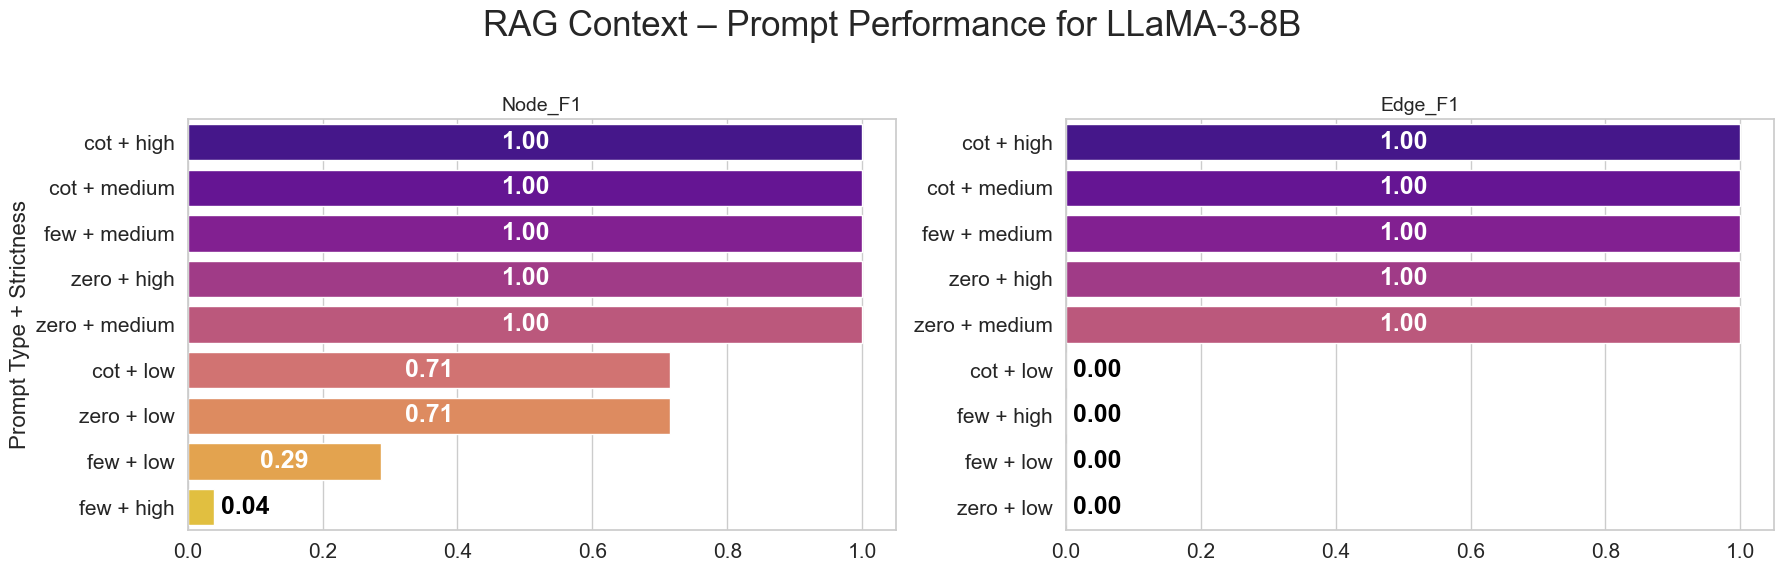

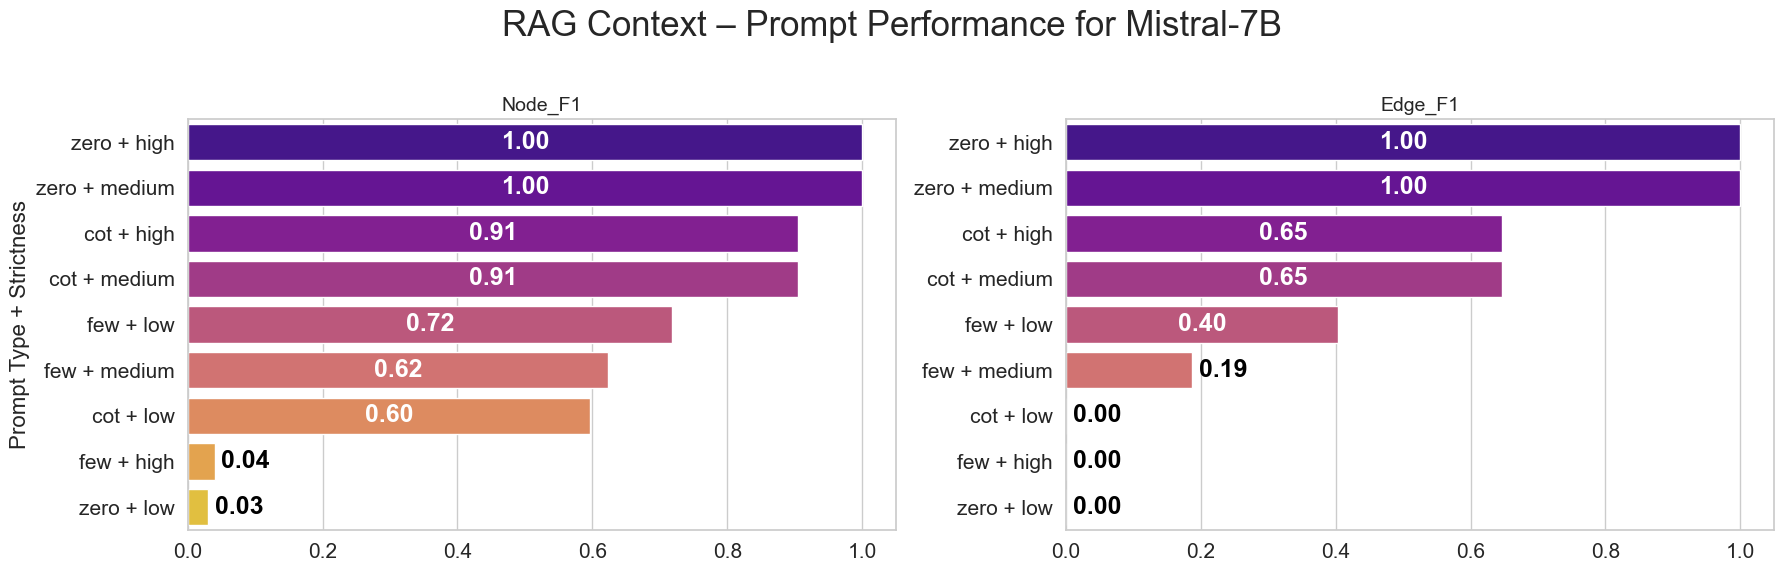

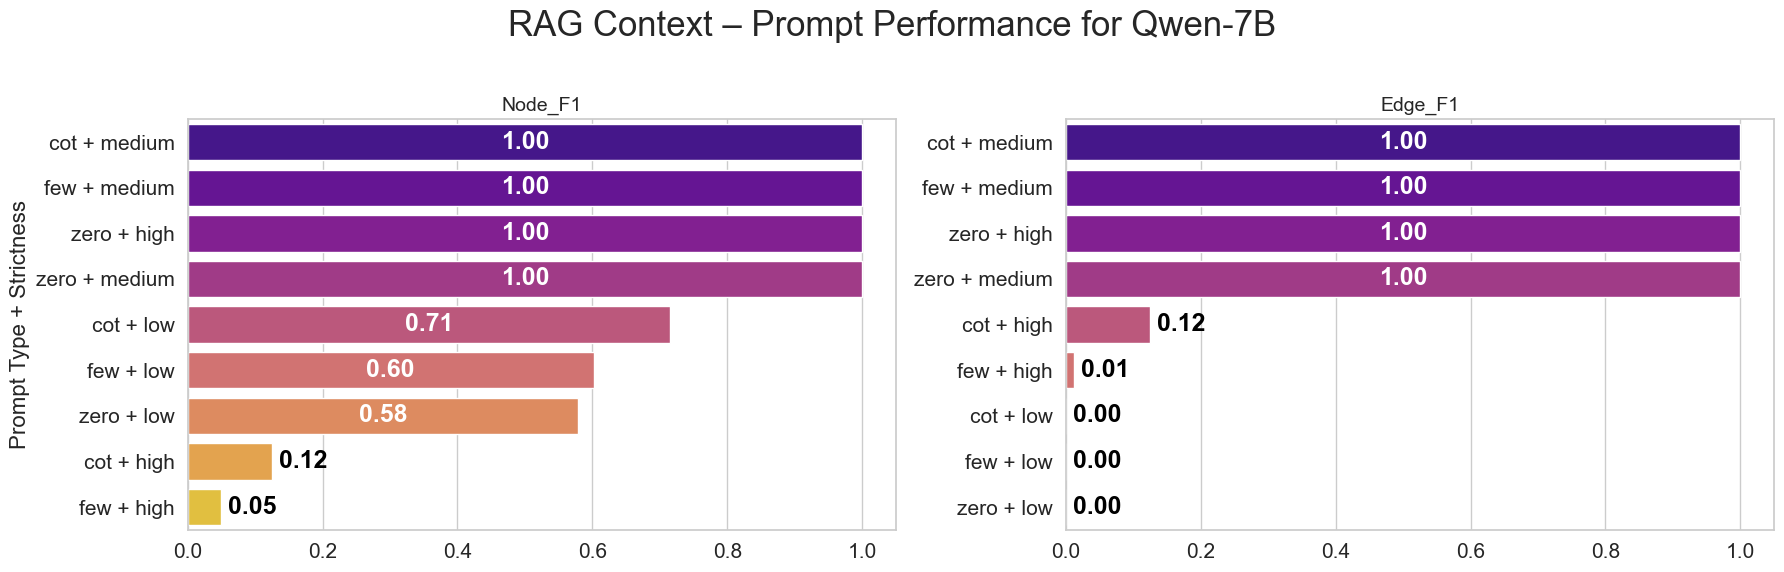

In [11]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset again
csv_path = Path("combined_sobol_run2_v2.csv")
df = pd.read_csv(csv_path)

# Filter to only RAG context
df = df[df['context_type'].str.lower() == 'rag']

# Combine prompt_type and strictness into a single label
df['prompt_combo'] = df['prompt_type'] + " + " + df['prompt_strictness'].astype(str)

# Aggregate metrics only for RAG
agg = df.groupby(['model', 'prompt_combo'])[['Node_F1', 'Edge_F1', 'GED']].mean().reset_index()

# Set seaborn style
sns.set(style="whitegrid")

# Plotting function
def plot_compact_metrics_rag_only():
    metrics = ['Node_F1', 'Edge_F1']
    for model in agg['model'].unique():
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        fig.suptitle(f"RAG Context – Prompt Performance for {model}", fontsize=25)

        for i, metric in enumerate(metrics):
            ax = axes[i]
            data = agg[agg['model'] == model].sort_values(metric, ascending=False)

            sns.barplot(
                data=data,
                x=metric,
                y='prompt_combo',
                hue='prompt_combo',
                palette='plasma',
                ax=ax
            )

            for bar, value in zip(ax.patches, data[metric]):
                width = bar.get_width()
                y_pos = bar.get_y() + bar.get_height() / 2
                label = f"{value:.2f}"

                if width < 0.2:
                    ax.text(
                        width + 0.01,
                        y_pos,
                        label,
                        ha='left',
                        va='center',
                        color='black',
                        fontsize=18,
                        fontweight='bold'
                    )
                else:
                    ax.text(
                        width / 2,
                        y_pos,
                        label,
                        ha='center',
                        va='center',
                        color='white',
                        fontsize=18,
                        fontweight='bold'
                    )

            ax.set_title(metric, fontsize=14)
            ax.set_xlabel('')
            ax.set_ylabel('' if i > 0 else 'Prompt Type + Strictness', fontsize=16)
            ax.tick_params(labelsize=15)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.savefig(f"{model}_rag_context_prompt_performance.png", dpi=300, bbox_inches='tight')
        plt.show()

# Generate the RAG-only plots
plot_compact_metrics_rag_only()


# Plotting variation

<Figure size 1600x800 with 0 Axes>

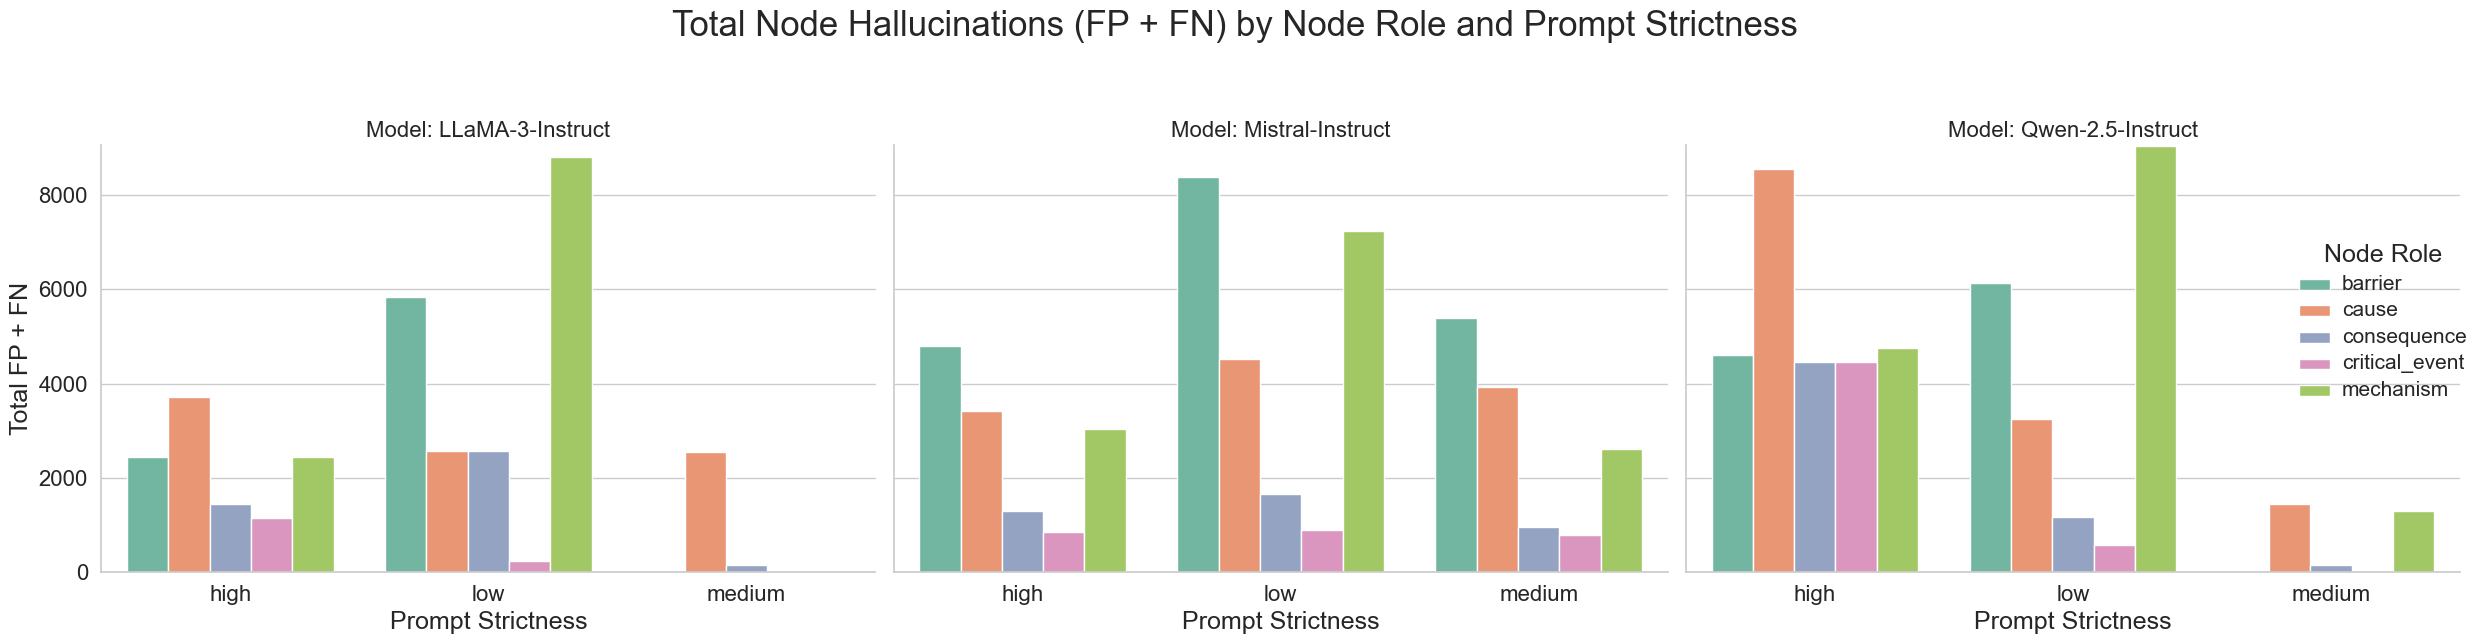

<Figure size 1600x800 with 0 Axes>

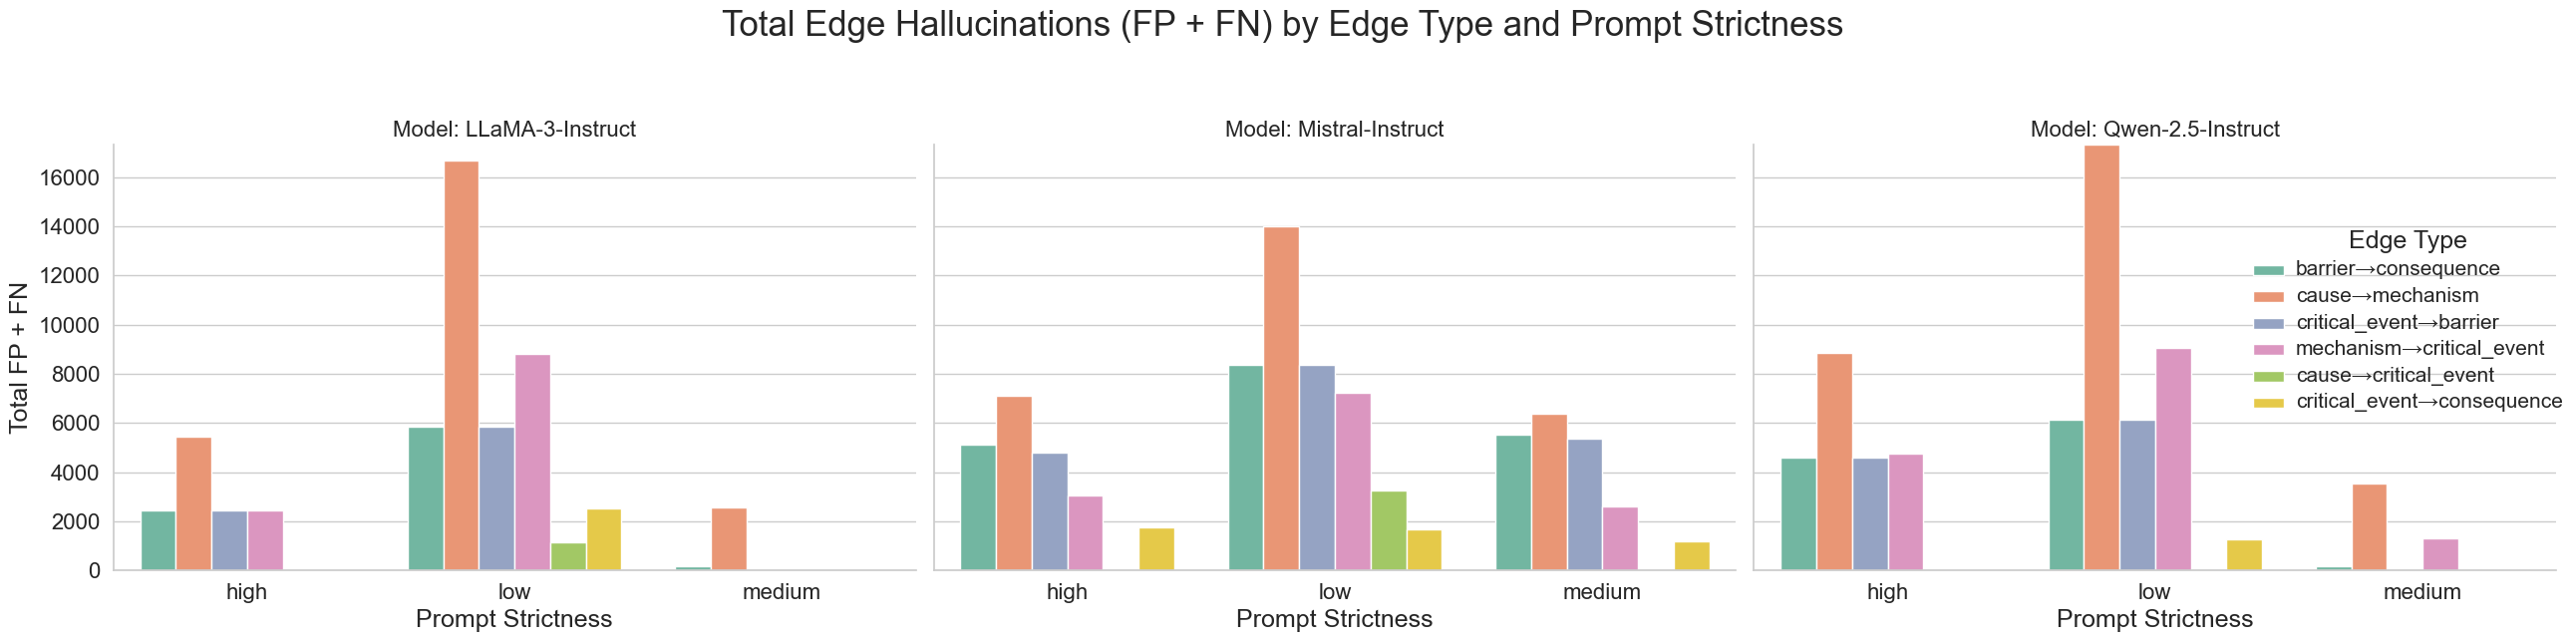

In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === File Paths ===
node_metrics_path = "/Users/priyank/Desktop/llm_rag/downloads/metrics_sobol2_v2_cleaned.xlsx"
sobol_metadata_path = "/Users/priyank/Desktop/Reuslts/sobol_metadata_individual_sensor_categorical.csv"

# === Load Sheets ===
node_metrics = pd.read_excel(node_metrics_path, sheet_name="NodeMetrics")
edge_metrics = pd.read_excel(node_metrics_path, sheet_name="EdgeMetrics")
sobol_metadata = pd.read_csv(sobol_metadata_path)

# === Prepare Metadata (fix filenames) ===
sobol_metadata["File"] = sobol_metadata["json_path"].apply(
    lambda x: os.path.basename(str(x)).replace(".json", "").replace(".txt", "")
)

# === Common Function: Summarize FP + FN ===
def summarize_fp_fn(df, role_col, label="Node"):
    df = df.copy()
    df[role_col] = df[role_col].astype(str).str.strip().str.lower()
    df = pd.merge(df, sobol_metadata[["File", "prompt_strictness", "model"]], on="File", how="left")
    df = df[~df[role_col].str.contains("overall")].copy()
    df["prompt_strictness"] = df["prompt_strictness"].astype(str)

    # === Remap model names ===
    model_name_map = {
        "LLaMA-3-8B": "LLaMA-3-Instruct",
        "Mistral-7B": "Mistral-Instruct",
        "Qwen-7B": "Qwen-2.5-Instruct"
    }
    df["model"] = df["model"].map(model_name_map).fillna(df["model"])

    summary = (
        df.groupby(["model", "prompt_strictness", role_col])
        .agg(
            total_FP=("FP", "sum"),
            total_FN=("FN", "sum"),
            total_CEs=("Critical Event", "nunique")
        )
        .reset_index()
    )

    summary["Total_FP_FN"] = summary["total_FP"] + summary["total_FN"]
    summary.rename(columns={role_col: "Role"}, inplace=True)
    summary["Type"] = label
    return summary


# === Summarize for Nodes and Edges ===
node_summary = summarize_fp_fn(node_metrics, role_col="Role", label="Node")
edge_summary = summarize_fp_fn(edge_metrics, role_col="Edge Type", label="Edge")

# Plot function with enhanced font sizes
def plot_faceted_summary_enhanced(summary_df, label):
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 8))

    g = sns.catplot(
        data=summary_df,
        x="prompt_strictness",
        y="Total_FP_FN",
        hue="Role",
        col="model",
        kind="bar",
        height=6,
        aspect=1.3,
        palette="Set2",
        legend=True
    )

    g.set_axis_labels("Prompt Strictness", "Total FP + FN")
    g.set_titles("Model: {col_name}")
    g.set(ylim=(0, summary_df["Total_FP_FN"].max() + 5))

    for ax in g.axes.flat:
        ax.title.set_size(16)
        ax.set_xlabel("Prompt Strictness", fontsize=18)
        ax.set_ylabel("Total FP + FN", fontsize=18)
        ax.tick_params(labelsize=16)

    suptitle = f"Total {label} Hallucinations (FP + FN) by {'Node Role' if label == 'Node' else 'Edge Type'} and Prompt Strictness"
    g.fig.suptitle(suptitle, fontsize=25, y=1.07)

    legend_title = "Node Role" if label == "Node" else "Edge Type"
    g._legend.set_title(legend_title)
    for text in g._legend.texts:
        text.set_fontsize(15)
    g._legend.set_title(legend_title, prop={'size': 18})

    plt.tight_layout()
    plt.show()

# Display plots
plot_faceted_summary_enhanced(node_summary, label="Node")
plot_faceted_summary_enhanced(edge_summary, label="Edge")

# Statistical Testing

In [52]:
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp
from cliffs_delta import cliffs_delta
from itertools import combinations

# === Load and prepare data ===
df = pd.read_csv("combined_sobol_run2_v2.csv")
df['prompt_type'] = df['prompt_type'].str.lower()
df['context_type'] = df['context_type'].str.lower()
df['PromptCombo'] = df['prompt_type'] + "_" + df['prompt_strictness'].astype(str)
df['model'] = df['model'].astype(str)

metrics = ["Node_F1", "Edge_F1"]
kruskal_results = []
dunn_results = []
cliff_results = []

# === Loop through each Model + Context combo ===
for model in df['model'].unique():
    for context in df['context_type'].unique():
        subset = df[(df['model'] == model) & (df['context_type'] == context)]

        if len(subset) < 3:
            continue

        for metric in metrics:
            for factor, label in [
                ('prompt_type', 'Prompt_Type'),
                ('prompt_strictness', 'Prompt_Strictness'),
                ('PromptCombo', 'PromptCombo')
            ]:
                grouped = [g[metric].dropna() for _, g in subset.groupby(factor)]

                if len(grouped) >= 2:
                    h, p = kruskal(*grouped)
                    kruskal_results.append({
                        "Model": model,
                        "Context": context,
                        "Metric": metric,
                        "Factor": label,
                        "H_stat": round(h, 3),
                        "p_value": round(p, 4)
                    })

                    # If significant, run Dunn + Cliff
                    if p < 0.05:
                        dunn = sp.posthoc_dunn(subset, val_col=metric, group_col=factor, p_adjust='bonferroni')
                        dunn['Model'] = model
                        dunn['Context'] = context
                        dunn['Metric'] = metric
                        dunn['Factor'] = label
                        dunn_results.append(dunn)

                        # Cliff's delta for each pair
                        for g1, g2 in combinations(subset[factor].unique(), 2):
                            values1 = subset[subset[factor] == g1][metric].dropna()
                            values2 = subset[subset[factor] == g2][metric].dropna()
                            if len(values1) > 1 and len(values2) > 1:
                                d = cliffs_delta(values1, values2)
                                cliff_results.append({
                                    "Model": model,
                                    "Context": context,
                                    "Metric": metric,
                                    "Factor": label,
                                    "Group_1": g1,
                                    "Group_2": g2,
                                    "Cliffs_Delta": d[0],
                                    "Magnitude": d[1]
                                })

# === Export results ===
pd.DataFrame(kruskal_results).to_csv("kruskal_results.csv", index=False)
if dunn_results:
    pd.concat(dunn_results).to_csv("dunn_posthoc_results.csv")
if cliff_results:
    pd.DataFrame(cliff_results).to_csv("cliffs_delta_results.csv", index=False)

print("✅ All results saved:")
print("- kruskal_results.csv")
print("- dunn_posthoc_results.csv")
print("- cliffs_delta_results.csv")


✅ All results saved:
- kruskal_results.csv
- dunn_posthoc_results.csv
- cliffs_delta_results.csv
